# **Methylation Biomarkers for Predicting Cancer**

## **Random Forest for Feature Selection**

**Author:** Meg Hutch

**Date:** February 14, 2020

**Objective:** Use random forest to select genes for features in our deep learning classifier.

#**To DOs:**

Figure out how to deal with accuracy for final evaluation - is accuracy the right method when we have multi-class classification? Need to read and ensure I'm using this correctly. **Update:** It seems that maybe the multi-class classification isn't neccessary?

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, f1_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score

In [2]:
# set working directory for git hub
import os
os.chdir('/home/mrh1996/')
#os.chdir('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/')
os. getcwd()

'/home/mrh1996'

**Import the training data**

In [3]:
mcTrain = pd.read_csv('Multi_Cancer_DL/02_Processed_Data/mcTrain_70_30.csv')

**Drop Un-neccessary columns**

In [4]:
mcTrain = mcTrain.drop(columns=["dilute_library_concentration", "age", "gender", "frag_mean"])

**Split Data into X inputs and Y outputs (diagnosis classification)**

In [5]:
mcTrain_x = mcTrain.drop(columns=["diagnosis"])
mcTrain_y = mcTrain[['seq_num','diagnosis']]

**Code the Categorical Data**

In [6]:
# Replace each outcome target with numerical value
mcTrain_y = mcTrain_y.replace('HEA', 0)
mcTrain_y = mcTrain_y.replace('CRC', 1)
mcTrain_y = mcTrain_y.replace('ESCA', 2)
mcTrain_y = mcTrain_y.replace('HCC', 3)
mcTrain_y = mcTrain_y.replace('STAD', 4)
mcTrain_y = mcTrain_y.replace('GBM', 5)
mcTrain_y = mcTrain_y.replace('BRCA', 6)

**Convert seq_num id to index**

In [7]:
mcTrain_x = mcTrain_x.set_index('seq_num')
mcTrain_y = mcTrain_y.set_index('seq_num')

**Split Training Data into a training/validation**

In [8]:
from sklearn.model_selection import train_test_split
np.random.seed(21420)
X_train, X_test, y_train, y_test = train_test_split(mcTrain_x, mcTrain_y, test_size=0.25, random_state=25, shuffle = True, stratify = mcTrain_y)

**Examine Disease Distributions After Training/Testing Split**

In [9]:
y_train_perc = y_train.groupby(['diagnosis']).size()/len(y_train)*100
y_test_perc = y_test.groupby(['diagnosis']).size()/len(y_test)*100

print(y_train_perc)
print(y_test_perc)

diagnosis
0    25.414365
1    18.784530
2     9.944751
3    20.441989
4    10.497238
5     7.734807
6     7.182320
dtype: float64
diagnosis
0    24.590164
1    18.032787
2     9.836066
3    19.672131
4    11.475410
5     8.196721
6     8.196721
dtype: float64


**One-hot encode y classes**

In [10]:
from sklearn import preprocessing
y_train_multi = preprocessing.label_binarize(y_train, classes=[0, 1, 2, 3, 4, 5, 6])
y_test_multi = preprocessing.label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6])

**Convert to arrays**

In [11]:
# save copy of X_train - this will be used for feature selection down the line
X_train_orig = X_train

# Convert all to arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values 
y_test = y_test.values

# **Random Forest**

The hyperparameter tuning function was adapted from Garrett's modeling lecture:

https://github.com/geickelb/HSIP442_guest_lecture/blob/master/notebooks/modeling.ipynb

scoring parameter for multi-classification: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter (will try f1_samples and precision_samples and/or just accuracy)

**Define Random Forest Hypertuning Function**

In [12]:
def hypertuning_fxn(X, y, nfolds, model , param_grid, scoring='accuracy', verbose=False): 
    """function that uses GridSearchCV to test a specified param_grid of hyperparameters and choose the optimal one based on nfolds cross-validation results. 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    X -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    cv -- if True, prints a the roc_auc score from 10-fold crossvalidation (dtype='boolean', default='True')
    """
    
    from sklearn.model_selection import KFold, GridSearchCV
    np.random.seed(12345)

    grid_search = GridSearchCV(estimator= model,
                                     param_grid=param_grid,
                                     cv=KFold(nfolds),
                                     scoring=scoring,
                                     return_train_score=True,
                                     n_jobs = -1)

        
    grid_search.fit(X, y)    
    print(" scorer function: {}".format(scoring))
    print(" ##### CV performance: mean & sd scores #####")

    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    print('best cv score: {:0.3f}'.format(grid_search.best_score_))
    print('best cv params: ', grid_search.best_params_)

    worst_index=np.argmin(grid_search.cv_results_['mean_test_score'])
    print('worst cv score: {:0.3f}'.format(grid_search.cv_results_['mean_test_score'][worst_index]))
    print('worst cv params: ', grid_search.cv_results_['params'][worst_index])
    ##
    if verbose==True:
        for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
   
    return(grid_search)

**Tune Hyperparameters**

In [26]:
### tuning RF hyperparameters
# Number of trees in random forest
n_estimators = [500] #  100, 300, 500, 1000
# Number of features to consider at every split
max_features = [3, 10, 'auto'] # 'auto' which is equivalent to sqrt(n_features)
# Maximum number of levels in tree
max_depth = [5, 8, 15, 25, 30]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 5, 10, 15]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

model = RandomForestClassifier(criterion='entropy', random_state=12345)

rf_hyper=hypertuning_fxn(X_train, y_train, nfolds=10, model=model , param_grid=param_grid, scoring='accuracy')

 scorer function: accuracy
 ##### CV performance: mean & sd scores #####
best cv score: 0.000
best cv params:  {'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
worst cv score: 0.000
worst cv params:  {'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


**Return the Best Estimator**

In [21]:
rf = rf_hyper.best_estimator_
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [22]:
multi_target_forest = MultiOutputClassifier(rf, n_jobs=-1) # n_jobs is the number of jobs to run in parallel. -1 means using all processors. 
multi_target_forest

MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='entropy',
                                                       max_depth=8,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=5,
                                                       min_weight_fraction_leaf=0.0,
                  

In [23]:
rf = multi_target_forest.fit(X_train, y_train)
predictions = rf.predict(X_test)
predictions

array([[0],
       [0],
       [0],
       [3],
       [0],
       [1],
       [0],
       [0],
       [3],
       [0],
       [0],
       [0],
       [0],
       [4],
       [3],
       [0],
       [3],
       [0],
       [1],
       [0],
       [0],
       [4],
       [0],
       [0],
       [3],
       [1],
       [0],
       [0],
       [1],
       [0],
       [3],
       [0],
       [3],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [4],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [3],
       [3],
       [3],
       [3],
       [4]])

In [24]:
# Probabilities for each class - this shows how predictions were made - not sure we need to do much more here
rf_probs = rf.predict_proba(X_test)[: 1]
# convert to an array
rf_probs = np.asarray(rf_probs)
# this helps reduce the list
rf_probs = np.amax(rf_probs, axis=0)
# convert to a dataframe
rf_probs = pd.DataFrame(rf_probs)
#print(rf_probs)

# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 1.82


In [25]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
#f1_score(y_test, predictions, average = 'samples') 

accuracy_score(y_test, predictions)

0.36065573770491804

# **Examine Important Features**

Feature Importance for Multi-class classification:
https://stackoverflow.com/questions/54562464/can-i-show-feature-importance-for-multioutputclassifier

MultiOutputClassifier objects have an attribute called estimators_. If you run multi_forest.estimators_, you will get a list containing an object for each of your RandomForest classifiers.

For each of these RandomForest classifier objects, you can access its feature importances through the feature_importances_ attribute.

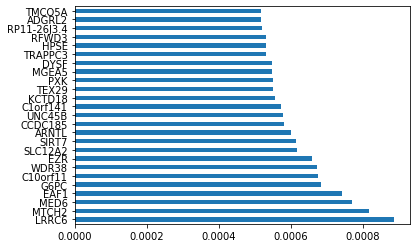

In [19]:
# create empty list
feat_impts = [] 
# bind all rf estimators for each classifier (each multi-class output - in our case 7)
for clf in rf.estimators_:
    feat_impts.append(clf.feature_importances_)

# calculate the mean of features across genes
feat = np.mean(feat_impts, axis=0)
# create a list of features (gene names)
features = list(X_train_orig.columns.values) 
# add gene names to the means
feat_importances = pd.Series(feat, index=X_train_orig.columns)  

# plot feature importance for nlargest means 
feat_importances.nlargest(25).plot(kind='barh')